In [1]:
import django
import pandas as pd
django.setup()

In [2]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from sch.models import *
import datetime as dt
from django.db.models import CharField
from django.test import RequestFactory
from sch.actions import *
from sch.views2 import *

In [51]:
from django.db.models import Sum

employee_hours = Schedule.objects.filter(slots__week__pk__in=range(1,7)) \
    .values('slot__employee') \
    .annotate(total_hours=Sum('slots__shift__hours')) \
    .order_by('employee')


FieldError: Cannot resolve keyword 'employee' into field. Choices are: action_log, id, last_update, number, percent, periods, scheduleemusr, slots, slug, start_date, status, tagged_items, tags, unfavorable_ratio, version, weeks, workdays, year

In [81]:
df = pd.DataFrame.from_dict(sortDict(tallies,reverse=True), orient='index', columns=['count'])
df

,count
Jaden,106
None,56
Tiffany,45
Josh,33
Esperanza,20
Trisha,19
Leslie,16
Brianna-A,10
David,7
Sabrina,6


<AxesSubplot:>

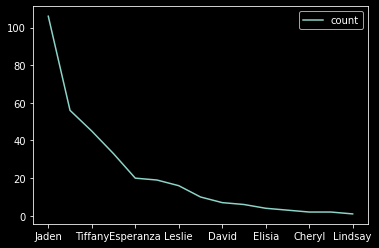

In [82]:
df.plot()

In [83]:
sch = Schedule.objects.first()

empls = Employee.objects.annotate(scheduleHours=Sum('slots__shift__hours')).order_by('-scheduleHours')
# standard schedule Hours should be 240 * the employees fte field
empls = empls.annotate(standardScheduleHours=240*F('fte'))
empls = empls.annotate(percentScheduled=F('scheduleHours')/F('standardScheduleHours')*100)
empls.values('name','scheduleHours','standardScheduleHours','percentScheduled')

<EmployeeManager [{'name': 'Elisia', 'scheduleHours': 2390.0, 'standardScheduleHours': 240.0, 'percentScheduled': 995.8333333333334}, {'name': 'Esperanza', 'scheduleHours': 2340.0, 'standardScheduleHours': 240.0, 'percentScheduled': 975.0}, {'name': 'Mona', 'scheduleHours': 2330.0, 'standardScheduleHours': 240.0, 'percentScheduled': 970.8333333333334}, {'name': 'Brittanie', 'scheduleHours': 2264.0, 'standardScheduleHours': 240.0, 'percentScheduled': 943.3333333333334}, {'name': 'Jaden', 'scheduleHours': 2240.0, 'standardScheduleHours': 240.0, 'percentScheduled': 933.3333333333334}, {'name': 'Brianna A', 'scheduleHours': 2230.0, 'standardScheduleHours': 240.0, 'percentScheduled': 929.1666666666666}, {'name': 'Danica', 'scheduleHours': 2200.0, 'standardScheduleHours': 240.0, 'percentScheduled': 916.6666666666666}, {'name': 'Michael', 'scheduleHours': 2090.0, 'standardScheduleHours': 210.0, 'percentScheduled': 995.2380952380953}, {'name': 'David', 'scheduleHours': 2000.0, 'standardSchedul

In [84]:
def sch_solve_with_lookbehind (request, schid):
    sch = Schedule.objects.get(slug=schid)
    success_bucket = []
    emptySlots = sch.slots.empty().order_by('?')
    for slot in emptySlots:
        if slot.workday.sd_id != 0:
            prev = slot.workday.prevWD().slots.filter(shift__start__hour__lte=slot.shift.start.hour+1, shift__start__hour__gte=slot.shift.start.hour-1)
            choices = []
            for p in prev:
                if p.streak < p.employee.streak_pref and p.employee not in choices and p.employee in slot.workday.on_deck():
                    choices.append(p.employee)
            if len(choices) > 0:
                chosen = random.choice(choices)
                if PtoRequest.objects.filter(employee=chosen, workday=slot.workday.date).exists() == False:
                    if TemplatedDayOff.objects.filter(employee=chosen, sd_id=slot.workday.sd_id).exists() == False:
                        try:
                            slot.employee = chosen
                            slot.save()
                            success_bucket.append(slot)
                        except:
                            print(f"ERROR: {slot} could not be filled")
                    else: 
                        print(f"{chosen} has a templated day off on {slot.workday.date}")
                else:
                    print(f"{chosen} has a PTO request on {slot.workday.date}")
            else:
                print(f"No choices for {slot}")
                try:
                    slot.employee = random.choice(workday.on_deck())
                    slot.save()
                    success_bucket.append(slot)
                except:
                    print(f"ERROR: Backup Fill via On Deck Employees Failed. This slot was not filled. {slot}")
        else:
            print(f"{slot} is on First Sunday of Schedule")
    print(len(success_bucket) , "slots filled via method SCHEDULE_SOLVE_WITH_LOOKBEHIND")
                    
                

In [85]:
sch_solve_with_lookbehind(None, '2022-S8A')


['Michael', 'Leslie', 'Brittanie', 'Lindsay', 'Mona', 'Brianna-A', 'David', 'Elisia', 'Trisha', 'Sabrina', 'Jaden', 'Nick', 'Mark', 'Mandy', 'Josh', 'Tiffany', 'Esperanza', 'Cheryl', None, 'Danica', 'Amanda']
['Michael', 'Leslie', 'Brittanie', 'Lindsay', 'Mona', 'Brianna-A', 'David', 'Elisia', 'Trisha', 'Sabrina', 'Jaden', 'Nick', 'Mark', 'Mandy', 'Josh', 'Tiffany', 'Esperanza', 'Cheryl', None, 'Danica', 'Amanda']
No choices for 221204-EP None
ERROR: Backup Fill via On Deck Employees Failed. This slot was not filled. 221204-EP None
['Michael', 'Leslie', 'Brittanie', 'Lindsay', 'Mona', 'Brianna-A', 'Josh', 'David', 'Elisia', 'Trisha', 'Jaden', 'Nick', 'Mark', 'Mandy', 'Cheryl', 'Tiffany', 'Esperanza', 'Sabrina', 'Danica', None, 'Amanda']
No choices for 221217-3 None
ERROR: Backup Fill via On Deck Employees Failed. This slot was not filled. 221217-3 None
['Michael', 'Leslie', 'Brittanie', 'Lindsay', 'Mona', 'Brianna-A', 'David', 'Elisia', 'Trisha', 'Sabrina', 'Jaden', 'Nick', 'Mark', 'Ma

In [86]:
valList = lambda list_ , val : list(list_.values_list(val,flat=True))

In [87]:
valList(sch.slots.filled(), 'employee')
sch.save()
sch.percent

95